# Autoencoder Classifier Hybrid Model
Autoencoders are artificial neural networks capable of learning dense representations of the input data, called **latent representation or codings,** without any supervision. These latent representation have much lower dimensionality and encode the different features of the input data. Thus, we can use this latent representation to do different tasks with much less computational load. In this notebook, let's take the encoder part of the Autoencoder and use it to predict the Sentiment of a IMDB Review.

In [1]:
import os
import re
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import spacy
from utils.plotting import HistoryPlotter

SEED = 42
np.random.seed(SEED)

# Preprocessing
The dataset contains the review in the "review" column and the sentiment in the "sentiment" column. Let's load the dataset and convert the sentiment column into integers of 0 if the review is positive and 1 if the review is negative. Also let's split the dataset for Training, Validation and Testing. The HTML tags in the input data are also removed.

In [2]:
dataset = pd.read_csv(os.path.expanduser("~\Downloads\datasets\IMDB-Dataset.csv"))
dataset['sentiment'] = dataset['sentiment'].map(lambda label: 0 if label=='positive' else 1)
# dataset = pd.read_csv("/content/drive/MyDrive/IMDB-Dataset.csv")
train_ae = dataset.iloc[:44000, 0]
val_ae = dataset.iloc[44000:47000, 0]
test_ae = dataset.iloc[47000:, 0]

train_y = dataset.iloc[:44000, 1]
val_y = dataset.iloc[44000:47000, 1]
test_y = dataset.iloc[47000:, 1]

print(train_ae.head())
print("\n", train_y.head())

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

 0    0
1    0
2    0
3    1
4    0
Name: sentiment, dtype: int64


In [3]:
print(train_ae[1][:190])
html_re = re.compile(r'<[^>]+>')
train_ae = train_ae.replace(html_re, "", regex=True)
val_ae = val_ae.replace(html_re, "", regex=True)
test_ae = test_ae.replace(html_re, "", regex=True)
print(train_ae[1][:190])

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the en
A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. 


# Tokenization
Tokenization is a way of separating a piece of text into smaller units called token, in this case into words. The purpose of tokenization is that we can use their corresponding token-id to represent the original text. We first create a vocabulary containing the counts of each word that occurs in the Training Set. Then we assign an index to the first 10000 most popular words, the rest of the words are given an index of 0, which is considered as an Out of Vocabulary word.

In [4]:
tokenizer = keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train_ae)
print("Word Indices: ")
print(dict(itertools.islice(tokenizer.index_word.items(), 20)), "...")
print(f"Word Count: {len(tokenizer.word_index)}")

Word Indices: 
{1: 'the', 2: 'and', 3: 'a', 4: 'of', 5: 'to', 6: 'is', 7: 'in', 8: 'it', 9: 'i', 10: 'this', 11: 'that', 12: 'was', 13: 'as', 14: 'for', 15: 'with', 16: 'movie', 17: 'but', 18: 'film', 19: 'on', 20: 'not'} ...
Word Count: 119224


In [5]:
MAX_NUM_TOKENS = 10000
tokenizer.num_words = MAX_NUM_TOKENS
train_ae = train_ae.apply(lambda x: tokenizer.texts_to_sequences([x])[0])
val_ae = val_ae.apply(lambda x: tokenizer.texts_to_sequences([x])[0])
test_ae = test_ae.apply(lambda x: tokenizer.texts_to_sequences([x])[0])

train_ae.head()

0    [26, 4, 1, 79, 2077, 44, 1059, 11, 98, 146, 38...
1    [3, 393, 119, 353, 1, 1350, 2947, 6, 51, 51, 1...
2    [9, 190, 10, 12, 3, 393, 94, 5, 1133, 54, 19, ...
3    [689, 221, 3, 232, 116, 3, 119, 426, 3595, 128...
4    [111, 7, 1, 54, 4, 287, 6, 3, 2074, 1438, 18, ...
Name: review, dtype: object

# Padding
Since each review has variable lengths, we can pad the shorter reviews to a particular length and truncate longer reviews to be the same length. The length is taken to be 300. Also, we pad/truncate the end of each review since in English Language most of the important information is present at the start, thus if we were to truncate the start of the sentence, we might lose more info.

In [6]:
print('sequence_length mean: ', train_ae.apply(lambda x: len(x)).mean())
print('sequence_length median: ', train_ae.apply(lambda x: len(x)).median())
print('sequence_length std deviation: ', np.sqrt(train_ae.apply(lambda x: len(x)).var()))
MAX_SEQUENCE_LENGTH = 300 # mean + std deviation*0.5

sequence_length mean:  217.23727272727274
sequence_length median:  164.0
sequence_length std deviation:  158.58784251928319


In [7]:
train_ae = keras.preprocessing.sequence.pad_sequences(train_ae, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
val_ae = keras.preprocessing.sequence.pad_sequences(val_ae, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_ae = keras.preprocessing.sequence.pad_sequences(test_ae, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print(train_ae)

[[  26    4    1 ...    0    0    0]
 [   3  393  119 ...    0    0    0]
 [   9  190   10 ...    0    0    0]
 ...
 [   1 3047    5 ...  391    3  701]
 [ 528   10   26 ...    0    0    0]
 [   9  152   24 ...    0    0    0]]


# Word to Vector
Now that each review is of the same length, the next step is to embed each of the index into unique vectors. We have 2 options in this step, using One Hot Encoders or using Word Embeddings. Since One Hot Encoders are really inefficient (size of vector = vocabulary size) and they don't have any relationship between the words, we will go with pretrained word embeddings. We will use Pretrained Models from the Spacy library for this.

In [8]:
word2vec_model = spacy.load("en_core_web_sm")

df_index_word = pd.Series(tokenizer.index_word) # Get all the words in the vocabulary
df_index_word = df_index_word[:MAX_NUM_TOKENS-1]
df_index_word = pd.Series(["temp_oov_word"]).append(df_index_word) # Add a temporary row for oov words
df_index_word = df_index_word.reset_index() # New column for token_id
df_index_word.columns = ['token_id', 'token']

df_index_word['word2vec'] = df_index_word.token.apply(lambda x: word2vec_model(x).vector) # Embedding for each word
df_index_word.at[0, "word2vec"] = np.zeros_like(df_index_word.at[0, "word2vec"]) # Replace the embedding for "temp_oov_word" with 0s
df_index_word.head()

,token_id,token,word2vec
0,0,temp_oov_word,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,the,"[-0.2032743, -0.4009009, -0.73730505, 0.536398..."
2,2,and,"[-0.9291044, -0.13172856, -0.814826, 0.6040276..."
3,3,a,"[0.02819018, 0.009864252, -0.095220566, 0.5522..."
4,4,of,"[-1.1193825, 0.18575507, -0.59173, -0.4724092,..."


In [9]:
embedding_matrix = np.array([vec for vec in df_index_word.word2vec.values])
print(embedding_matrix.shape) # MAX_NUM_TOKENS x vector dim 
embedding_matrix[0:3, :5]

(10000, 96)


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.2032743 , -0.4009009 , -0.73730505,  0.5363982 ,  0.3764372 ],
       [-0.9291044 , -0.13172856, -0.814826  ,  0.6040276 , -0.67340827]],
      dtype=float32)

In [10]:
# MAX_NUM_TOKENS = 20000
# MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = embedding_matrix.shape[1] # 96
embedding_layer = keras.layers.Embedding(
    input_dim=MAX_NUM_TOKENS,
    output_dim=EMBEDDING_DIM,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_SEQUENCE_LENGTH,
    mask_zero=True,
    trainable=False)

# test
embedding_result = embedding_layer(inputs=train_ae[0])
print(embedding_result.shape) # MAX_SEQUENCE_LENGTH x EMBEDDING_DIM
print("Embeddings of the first 5 words (each vector is restricted to size 5)")
print(train_ae[0][:5])
print(embedding_result[:5, :5]) 

train_ae = embedding_layer(inputs=train_ae)
val_ae = embedding_layer(inputs=val_ae)
test_ae = embedding_layer(inputs=test_ae)

(300, 96)
Embeddings of the first 5 words (each vector is restricted to size 5)
[  26    4    1   79 2077]
tf.Tensor(
[[ 0.49959356  0.704657    0.4497372   0.32913145  0.01701519]
 [-1.1193825   0.18575507 -0.59173    -0.4724092   0.04607756]
 [-0.2032743  -0.4009009  -0.73730505  0.5363982   0.3764372 ]
 [-0.33528453 -0.5446908   0.7285543  -0.51831293  0.10952553]
 [-0.39640257  0.09997782 -0.0515418   0.10987999  0.6886112 ]], shape=(5, 5), dtype=float32)


# Convolutional Autoencoder
An Autoencoder is built using Conv1D Layers with MaxPooling in the Encoder and Conv1DTranspose and BatchNormalization Layers in the Decoder. Each sample of length $(300 \times 96)$ is reduces to a latent representation of $(50 \times 1)$ which hopefully captures all the meaningful data in the input. This representation is then used to reconstruct the input. 

In [11]:
conv_encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=96, kernel_size=8, strides=2, input_shape=[MAX_SEQUENCE_LENGTH, EMBEDDING_DIM]),
    keras.layers.MaxPool1D(pool_size=2),
    keras.layers.Activation('relu'),
    
    keras.layers.Conv1D(filters=128, kernel_size=16, strides=1),
    keras.layers.MaxPool1D(pool_size=4),
    keras.layers.Activation('relu'),
    
    keras.layers.Conv1D(filters=50, kernel_size=14),
    keras.layers.Reshape([50])
])
conv_encoder.summary()
conv_decoder = keras.models.Sequential([
    # kernel size and strides are chosen such that we get 300x96 = 28800 = 180x160 size.
    keras.layers.Reshape([50,1], input_shape=[50]),
    keras.layers.Conv1DTranspose(64, kernel_size=8, padding='valid', activation='linear', input_shape=[1,50]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1DTranspose(128, kernel_size=32, strides=2, padding='valid', activation='linear'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1DTranspose(160, kernel_size=37, strides=1, padding='valid', activation='linear'),
    keras.layers.BatchNormalization(),
    keras.layers.Reshape([MAX_SEQUENCE_LENGTH, EMBEDDING_DIM])
])
conv_decoder.summary()
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 147, 96)           73824     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 73, 96)            0         
_________________________________________________________________
activation (Activation)      (None, 73, 96)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 58, 128)           196736    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 14, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 50)             8

In [12]:
conv_ae.compile(optimizer='adam', loss='mse')
conv_ae_history = conv_ae.fit(x=train_ae, y=train_ae, epochs=20, batch_size=256, validation_data=(val_ae, val_ae))

Epoch 1/20
172/172 [==============================] - 40s 56ms/step - loss: 0.8150 - val_loss: 0.5757
Epoch 2/20
172/172 [==============================] - 9s 52ms/step - loss: 0.5847 - val_loss: 0.4714
Epoch 3/20
172/172 [==============================] - 9s 54ms/step - loss: 0.4339 - val_loss: 0.3652
Epoch 4/20
172/172 [==============================] - 9s 54ms/step - loss: 0.3342 - val_loss: 0.2872
Epoch 5/20
172/172 [==============================] - 9s 54ms/step - loss: 0.2720 - val_loss: 0.2407
Epoch 6/20
172/172 [==============================] - 9s 54ms/step - loss: 0.2358 - val_loss: 0.2217
Epoch 7/20
172/172 [==============================] - 9s 54ms/step - loss: 0.2164 - val_loss: 0.2092
Epoch 8/20
172/172 [==============================] - 9s 54ms/step - loss: 0.2068 - val_loss: 0.2040
Epoch 9/20
172/172 [==============================] - 9s 54ms/step - loss: 0.2025 - val_loss: 0.2015
Epoch 10/20
172/172 [==============================] - 9s 54ms/step - loss: 0.2007 - val_l

Test Set metrics and Training History:
94/94 [==============================] - 0s 5ms/step - loss: 0.1990


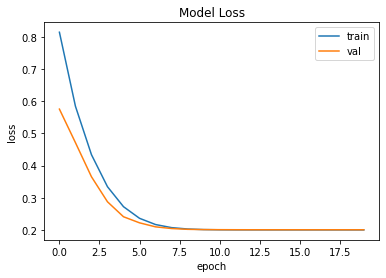

In [14]:
print(f"Test Set metrics and Training History:")
conv_ae.evaluate(x=test_ae, y=test_ae)
np.save("./models/conv_ae.npy", conv_ae_history.history)
# conv_ae_history = np.load("./models/conv_ae.npy", allow_pickle='TRUE').item()
conv_ae_plot = HistoryPlotter(history=conv_ae_history.history, accuracy_line=None, max_y_lim=[0.5, 1])
conv_ae_plot.all(row_col=[1,0])

# Pre Trained Classifier
The Encoder is fitted with a few dense layers that can be used for classification.

In [18]:
encoder_classifier = keras.models.clone_model(conv_encoder)
encoder_classifier.add(keras.layers.Dense(40, activation='selu', activity_regularizer='l2'))
encoder_classifier.add(keras.layers.Dense(20, activation='selu', activity_regularizer='l2'))
encoder_classifier.add(keras.layers.Dense(1, activation='sigmoid'))
encoder_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 147, 96)           73824     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 73, 96)            0         
_________________________________________________________________
activation (Activation)      (None, 73, 96)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 58, 128)           196736    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 14, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 50)             8

In [19]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, verbose=1, restore_best_weights=True)
encoder_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
encoder_classifier_history = encoder_classifier.fit(x=train_ae, y=tf.convert_to_tensor(train_y), epochs=30, batch_size=256, validation_data=(val_ae, tf.convert_to_tensor(val_y)), callbacks=[early_stopping])

Epoch 1/30
172/172 [==============================] - 5s 21ms/step - loss: 0.7508 - accuracy: 0.5066 - val_loss: 0.6920 - val_accuracy: 0.5223
Epoch 2/30
172/172 [==============================] - 4s 21ms/step - loss: 0.6437 - accuracy: 0.6328 - val_loss: 0.6058 - val_accuracy: 0.6783
Epoch 3/30
172/172 [==============================] - 3s 20ms/step - loss: 0.5539 - accuracy: 0.7282 - val_loss: 0.5724 - val_accuracy: 0.7140
Epoch 4/30
172/172 [==============================] - 3s 20ms/step - loss: 0.4758 - accuracy: 0.7879 - val_loss: 0.5370 - val_accuracy: 0.7327
Epoch 5/30
172/172 [==============================] - 3s 20ms/step - loss: 0.4065 - accuracy: 0.8294 - val_loss: 0.5942 - val_accuracy: 0.7107
Epoch 6/30
172/172 [==============================] - 3s 20ms/step - loss: 0.3212 - accuracy: 0.8794 - val_loss: 0.6023 - val_accuracy: 0.7410
Epoch 7/30
172/172 [==============================] - 3s 20ms/step - loss: 0.2365 - accuracy: 0.9231 - val_loss: 0.7110 - val_accuracy: 0.7203

Test Set metrics and Training History:
94/94 [==============================] - 0s 3ms/step - loss: 0.5336 - accuracy: 0.7613


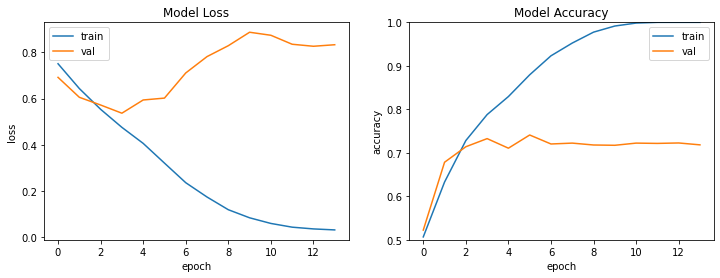

In [20]:
print(f"Test Set metrics and Training History:")
encoder_classifier.evaluate(x=test_ae, y=tf.convert_to_tensor(test_y))
np.save("./models/encoder_classifier.npy", encoder_classifier_history.history)
# encoder_classifier_history = np.load("./models/encoder_classifier.npy", allow_pickle='TRUE').item()
encoder_classifier_plot = HistoryPlotter(history=encoder_classifier_history.history, accuracy_line=None, max_y_lim=[0.5, 1])
encoder_classifier_plot.all(row_col=[1,0])

# Conclusion
The final Test Set Evaluation shows that the model is not particularly good at classifying whether a review is positive or negative, this is caused due to the **overfitting** of the `encoder_classifier` model on the Training Set. Also, the final result is achieved after experimenting with various hyperparameters and with various different Layer. Conv2D Layers were also used instead of Conv1D, but the latter had a much better Validation Accuracy. If I were to do this experiment over again, I would first try a baseline model by learning the Word Embeddings instead of using pretrained ones and also write a custom Metric to view the performance of the `conv_ae` model.